In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import math

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
device

'cuda'

# Embedding + Positional embeddings + multiheadattention + feedforward network

In [128]:
dropout_prob = 0.2
class Embedding(nn.Module):

  def __init__(self, vocab_size, embed_size):
    super().__init__()
    self.token_embeddings = nn.Embedding(vocab_size, embed_size)
  
  def forward(self, input):
    out = self.token_embeddings(input)
    # print(out.shape)
    return out

class PositionalEmbedding(nn.Module):
  """For every token in context length we will generate a positional encoding"""

  def __init__(self, context_len, embed_size):
    super().__init__()
    pos_encoding = torch.zeros(context_len, embed_size)
    for pos in range(context_len):
      for i in range(0,embed_size,2):
        pos_encoding[pos,i] = math.sin(pos / (10000 ** ((2 * i)/embed_size)))
        pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embed_size)))
    pos_encoding = pos_encoding.unsqueeze(dim=0)
    pos_encoding = pos_encoding
    # self.dropout = nn.Dropout(dropout_prob)
    self.register_buffer('pe',pos_encoding)
  
  def forward(self, input):
    context_len = input.shape[1]
    # print(context_len)
    # print(input.shape)
    # print(self.pe[:,:context_len].shape)
    input = input + self.pe[:,:context_len,:]
    # input = input + torch.autograd.Variable(self.pe[:,:context_len],requires_grad=False)
    return input
#------self attention with single head----------#
class Head(nn.Module):

  def __init__(self,head_size,embed_size,context_length,causal_mask=True):
    super().__init__()

    self.query = nn.Linear(embed_size, head_size, bias=False)
    self.key = nn.Linear(embed_size, head_size, bias=False)
    self.value = nn.Linear(embed_size, head_size, bias=False)
    self.dropout = nn.Dropout(dropout_prob)
    self.causal_mask = causal_mask
    
  
  def forward(self, q, k, v, mask=None):
    # batch_size, context_len, embed_size = q.shape
    batch_size = q.shape[0]
    output_context_len = q.shape[1]
    input_context_len = k.shape[1]
    embed_size = q.shape[2]
    tril = torch.tril(torch.ones(output_context_len, input_context_len)).to(device)
    # if self.causal_mask:
    #   self.register_buffer('tril',torch.tril(torch.ones(output_context_len, input_context_len)))
    q = self.query(q)
    k = self.key(k)
    v = self.value(v)
    # print(q.shape, k.shape, v.shape)
    weights = q @ k.transpose(-2,-1) * embed_size**-0.5
    # print(weights.shape)
    # print(self.tril.shape)
    if mask is not None:
      weigths = weights.masked_fill(mask[:,None, None, :] == 0, float('-inf'))
    if self.causal_mask:
      # print(self.tril.shape)
      weights = weights.masked_fill(tril[:output_context_len,:input_context_len]==0, float('-inf'))
    # print(weights[0])
    weights = F.softmax(weights, dim=-1)
    weights = self.dropout(weights)
    out = weights @ v
    return out
#-----multihead attention------#
class MultiHeadAttention(nn.Module):

  def __init__(self, num_heads, head_size,embed_size,context_length,causal_mask=True):
    super().__init__()
    self.multiheads = nn.ModuleList([Head(head_size,embed_size,context_length,causal_mask) for _ in range(num_heads)])
    self.projection = nn.Linear(embed_size, embed_size)
    self.dropout = nn.Dropout(dropout_prob)
  
  def forward(self,q,k,v,mask=None):
    out = torch.cat([h(q,k,v,mask) for h in self.multiheads], dim = -1)
    return self.dropout(self.projection(out))
#---------Feedforward--------------#
class FeedForward(nn.Module):
  """Self attention while calculates the interactions among the tokens the feedforward will train the model on
  individual tokens and try to extract the information individually"""
  def __init__(self,embed_size):
    super().__init__()
    self.neural_net = nn.Sequential(
        nn.Linear(embed_size, 4 * embed_size), # multiplying by 4 as per the paper 'attention is all you need', this expands the hidden layer
        nn.GELU(),
        nn.Linear(4 * embed_size, embed_size), #--projection layer 
        nn.Dropout(dropout_prob)
    )
  def forward(self, x):
    return self.neural_net(x)




In [76]:
torch.manual_seed(56)
q = torch.randint(2,100,(8,512,64))
k = torch.randint(2,100,(8,256,64))
weights = q @ k.transpose(-2,-1)

In [77]:
k.transpose(-2,-1).shape

torch.Size([8, 64, 256])

In [78]:
weights.shape

torch.Size([8, 512, 256])

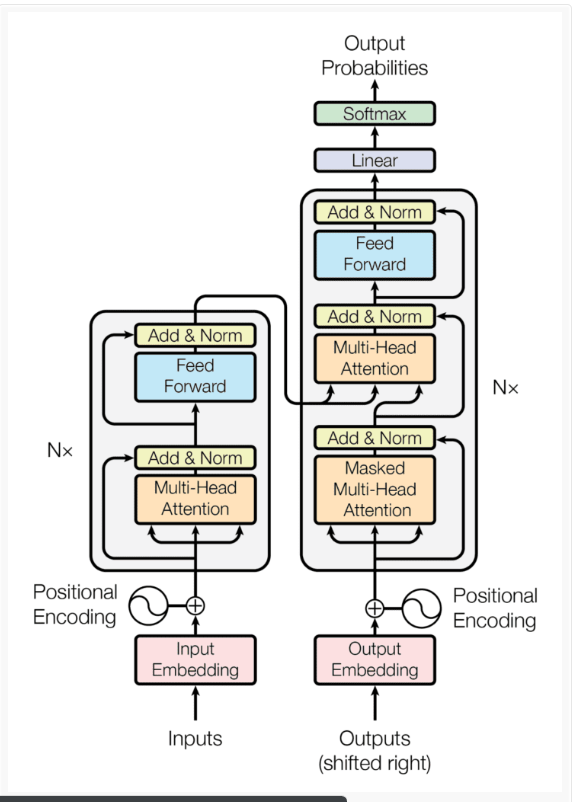

## Encoder

In [129]:
class EncoderBlock(nn.Module):

  def __init__(self,num_heads,embed_size,context_length,causal_mask=False):
    super().__init__()
    head_size = embed_size // num_heads
    self.multiheads = MultiHeadAttention(num_heads, head_size,embed_size,context_length,causal_mask)
    self.feedforward = FeedForward(embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.dropout1 = nn.Dropout(dropout_prob)
    self.dropout2 = nn.Dropout(dropout_prob)

  def forward(self, input, mask=None):
    #adding residual connection
    input = input + self.dropout1(self.multiheads(self.ln1(input),self.ln1(input),self.ln1(input), mask))
    input = input + self.dropout2(self.feedforward(self.ln2(input)))
    return input

class Encoder(nn.Module):

  def __init__(self, num_blocks, context_length, embed_size, num_heads, head_size, vocab_size,causal_mask=False):
    super().__init__()
    self.embeddings = Embedding(vocab_size,embed_size)
    self.position_embeddings = PositionalEmbedding(context_length, embed_size)
    self.encoder_blocks = nn.Sequential(*[EncoderBlock(num_heads, embed_size,context_length,causal_mask) for _ in range(num_blocks)])
    # self.linear_layer = nn.Linear(embed_size) # to predict classes for every sample in multiclass classification
    self.layerNorm = nn.LayerNorm(embed_size)

  def forward(self, input, mask=None):
    embed_output = self.embeddings(input)
    pos_out = self.position_embeddings(embed_output)
    for block in self.encoder_blocks:
      pos_out = block(pos_out, mask)
    #----pos_out is of dimension batch_size x context_len x embed_size----#
    #-----we can 0 out context and perform predictions batch or sample wise-----#
    # out = pos_out[:,0,:] # retaining num_samples and their corresponding embeddings
    # out = self.linear_layer(self.layerNorm(out))
    out = self.layerNorm(pos_out)
    return out

### Testing the encoder

In [ ]:
num_blocks, context_length, embed_size, num_heads, head_size, vocab_size, batch_size,num_clases = 2, 1024, 64, 4, 16, 20000, 64,5

In [ ]:
model = Encoder(num_blocks, context_length, embed_size, num_heads, head_size, vocab_size)

In [ ]:
model.to(device)

In [ ]:
x = torch.randint(0,20000,(8,512))
x = x.to(device)
mask = torch.ones((8,512))
mask[:,256:] = 0
mask = mask.to(device)

In [ ]:
mask = torch.ones((8,512))
mask[:,256:] = 0
mask = mask.to(device)

In [ ]:
y = model(x, mask)

In [ ]:
y.shape

torch.Size([8, 5])

In [ ]:
# !pip install transformers datasets

## Decoder

In [130]:
class DecoderBlock(nn.Module):

  def __init__(self, num_heads, embed_size,context_length):
    super().__init__()
    head_size = embed_size // num_heads
    self.masked_multiheads = MultiHeadAttention(num_heads, head_size,embed_size,context_length,causal_mask=True)
    self.multiheads = MultiHeadAttention(num_heads, head_size,embed_size,context_length,causal_mask=False)
    self.feedforward = FeedForward(embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.ln3 = nn.LayerNorm(embed_size)
    self.dropout1 = nn.Dropout(dropout_prob)
    self.dropout2 = nn.Dropout(dropout_prob)
    self.dropout3 = nn.Dropout(dropout_prob)

  def forward(self,decoder_input,encoder_output,enc_mask=None,dec_mask=None):
    #adding residual connection
    decoder_input = decoder_input + self.dropout1(self.masked_multiheads(self.ln1(decoder_input),self.ln1(decoder_input),self.ln1(decoder_input), mask = dec_mask))
    decoder_input = decoder_input + self.dropout1(self.masked_multiheads(self.ln2(decoder_input),self.ln2(encoder_output),self.ln2(encoder_output), mask = enc_mask))
    decoder_input  = decoder_input + self.dropout3(self.feedforward(self.ln3(decoder_input)))
    return decoder_input

class Decoder(nn.Module):

  def __init__(self, num_blocks, context_length, embed_size, num_heads, head_size, vocab_size):
    super().__init__()
    self.embeddings = Embedding(vocab_size,embed_size)
    self.position_embeddings = PositionalEmbedding(context_length, embed_size)
    self.decoder_blocks = nn.Sequential(*[DecoderBlock(num_heads, embed_size,context_length) for _ in range(num_blocks)])
    self.ln1 = nn.LayerNorm(embed_size)
    self.linear_layer = nn.Linear(embed_size, vocab_size)
  
  def forward(self, dec_input, enc_output,enc_mask = None,dec_mask=None):
    embed_output = self.embeddings(dec_input)
    pos_out = self.position_embeddings(embed_output) #----these are our inputs to the block
    for block in self.decoder_blocks:
      pos_out = block(pos_out, enc_output, enc_mask, dec_mask)
    out = self.ln1(pos_out)
    out = self.linear_layer(out)
    # out_probs = F.softmax(self.linear_layer(pos_out), dim = -1)
    return out

# Transformer (encoder + decoder)

In [131]:
class Transformer(nn.Module):

  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  
  def forward(self, enc_input, dec_input, enc_mask=None, dec_mask=None):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(dec_input,enc_output,enc_mask,dec_mask)
    return dec_output



In [132]:
encoder = Encoder(vocab_size = 20000,
                  context_length = 512,
                  num_blocks = 2,
                  num_heads = 4,
                  embed_size = 64,
                  head_size = 16,

    
)
decoder = Decoder(vocab_size = 10000,
                  context_length = 256,
                  num_blocks = 2,
                  num_heads = 4,
                  embed_size = 64,
                  head_size = 16,
    
)
transformer = Transformer(encoder, decoder)

In [133]:
encoder.to(device)
decoder.to(device)

Decoder(
  (embeddings): Embedding(
    (token_embeddings): Embedding(10000, 64)
  )
  (position_embeddings): PositionalEmbedding()
  (decoder_blocks): Sequential(
    (0): DecoderBlock(
      (masked_multiheads): MultiHeadAttention(
        (multiheads): ModuleList(
          (0-3): 4 x Head(
            (query): Linear(in_features=64, out_features=16, bias=False)
            (key): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (projection): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (multiheads): MultiHeadAttention(
        (multiheads): ModuleList(
          (0-3): 4 x Head(
            (query): Linear(in_features=64, out_features=16, bias=False)
            (key): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_feature

In [136]:
enc_input = torch.randint(0,20000,(8,512))
enc_input = enc_input.to(device)
enc_mask = torch.ones((8,512))
enc_mask[:,256:] = 0
enc_mask = enc_mask.to(device)

dec_input = torch.randint(0,10000,(8,256))
dec_input = dec_input.to(device)
dec_mask = torch.ones((8,256))
dec_mask[:,128:] = 0 # 0 means pad
dec_mask = dec_mask.to(device)

out = transformer(enc_input, dec_input, enc_mask, dec_mask)

In [137]:
out.shape

torch.Size([8, 256, 10000])

# Translation task using transformer

In [140]:
!wget -nc https://raw.githubusercontent.com/PacktPublishing/The-Deep-Learning-Challenge/master/Section%205/source/spa-eng/spa.txt

--2023-04-29 16:14:32--  https://raw.githubusercontent.com/PacktPublishing/The-Deep-Learning-Challenge/master/Section%205/source/spa-eng/spa.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8152302 (7.8M) [text/plain]
Saving to: ‘spa.txt’

spa.txt             100%[===================>]   7.77M  --.-KB/s    in 0.08s   

2023-04-29 16:14:33 (92.5 MB/s) - ‘spa.txt’ saved [8152302/8152302]



In [141]:
import pandas as pd
df = pd.read_csv("spa.txt",sep="\t",header=None)
df.head()

,0,1
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [142]:
df = df.iloc[:30000]

In [143]:
df.columns = ['en','es']
df.to_csv("spa.csv", index=None)

In [ ]:
!pip install transformers datasets sentencepiece sacremoses

In [146]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='spa.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-af602469b9bcdb95/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [147]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 30000
    })
})

In [148]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['en', 'es'],
        num_rows: 9000
    })
})

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Test our tokenizer on sentences

In [151]:
en_sentence = split["train"][0]["en"]
es_sentence = split["train"][0]["es"]
inputs = tokenizer(en_sentence)
targets = tokenizer(text_target=es_sentence)
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁¡', 'Qué', '▁confusión', '!', '</s>']

In [152]:
es_sentence

'¡Qué confusión!'

In [153]:
en_sentence

'What a mess!'

In [154]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
  model_inputs = tokenizer(
      batch['en'], max_length=max_input_length, truncation=True)
  
  labels = tokenizer(
      text_target=batch['es'], max_length=max_target_length,
      truncation=True
  )
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs


In [155]:
tokenized_datasets = split.map(
    preprocess_function,
    batched=True,
    remove_columns=split["train"].column_names,
)

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [156]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9000
    })
})

In [157]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [158]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0,5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [159]:
batch['input_ids']

tensor([[  184,     8, 12800,    55,     0, 65000, 65000, 65000],
        [   33,    88,  3159,  1176,     3,     0, 65000, 65000],
        [   33,  2319,  5266,  4939,  4963,     3,     0, 65000],
        [  160,  4117,   640,  1237,     3,     0, 65000, 65000],
        [ 1093,    20,     9,   333,   138, 24740,    55,     0]])

In [160]:
batch['attention_mask']

tensor([[1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])

In [161]:
batch['labels']

tensor([[  107,   278, 16769,    55,     0,  -100,  -100,  -100,  -100],
        [  711,  1039,  1437,  2197,     3,     0,  -100,  -100,  -100],
        [ 1802,     8,  5266, 27610,   380,     8,  4963,     3,     0],
        [37399,  8858,    36,     6,  1161,     3,     0,  -100,  -100],
        [  107,   126,   555,  2627, 12224,    55,     0,  -100,  -100]])

In [162]:
tokenizer.all_special_ids

[0, 1, 65000]

In [163]:
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>']

In [164]:
tokenizer('<pad>')

{'input_ids': [65000, 0], 'attention_mask': [1, 1]}

In [165]:
from torch.utils.data import DataLoader
train_loader = DataLoader(tokenized_datasets['train'],
                          shuffle = True,
                          batch_size = 32,
                          collate_fn = data_collator)
valid_loader = DataLoader(tokenized_datasets['test'],
                          batch_size = 32,
                          collate_fn = data_collator)

In [169]:
for batch in train_loader:
  for k, v in batch.items():
    print("k:", k, "v.shape", v.shape)
  break

k: input_ids v.shape torch.Size([32, 10])
k: attention_mask v.shape torch.Size([32, 10])
k: labels v.shape torch.Size([32, 10])


In [170]:
tokenizer.vocab_size

65001

In [174]:
tokenizer.add_special_tokens({"cls_token":"<s>"})

1

In [175]:
tokenizer("<s>")

{'input_ids': [65001, 0], 'attention_mask': [1, 1]}

In [176]:
tokenizer.vocab_size

65001

it should have been 65002 since we have added a cls_token 

In [177]:
encoder = Encoder(vocab_size = tokenizer.vocab_size + 1,
                  context_length = 512,
                  num_blocks = 2,
                  num_heads = 4,
                  embed_size = 64,
                  head_size = 16,

    
)
decoder = Decoder(vocab_size = tokenizer.vocab_size + 1,
                  context_length = 512,
                  num_blocks = 2,
                  num_heads = 4,
                  embed_size = 64,
                  head_size = 16,
    
)
transformer = Transformer(encoder, decoder)

In [178]:
device

'cuda'

In [ ]:
encoder.to(device)
decoder.to(device)

In [180]:
criterion = nn.CrossEntropyLoss(ignore_index=-100) #ignore padding tokens
optimizer = torch.optim.Adam(transformer.parameters())

In [186]:
x = [2,4,5]
x

[2, 4, 5]

In [190]:
torch.mean(torch.tensor(x,dtype=float)).item()

3.6666666666666665

In [193]:
from datetime import datetime
import numpy as np
# model training

def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)

  for i in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for batch in train_loader:
      batch = {k: v.to(device) for k , v in batch.items()}
      optimizer.zero_grad()

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      # shift targets to get decoder input
      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:,0] = 65_001 # all start tokens would be <s>
      # convert all -100 to pad token id 
      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id
      )

      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)
      # forward pass
      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2,1), targets)

      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = torch.mean(torch.tensor(train_loss,dtype=float)) #average loss

    model.eval()
    test_loss = []
    # n_test = 0
    for batch in valid_loader:
      batch = {k: v.to(device) for k , v in batch.items()}
      optimizer.zero_grad()

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      # shift targets to get decoder input
      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:,0] = 65_001 # all start tokens would be <s>
      # convert all -100 to pad token id 
      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id
      )

      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(
          dec_input == tokenizer.pad_token_id, 0)
      # forward pass
      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2,1), targets)

      loss.backward()
      optimizer.step()
      test_loss.append(loss.item())
    test_loss = torch.mean(torch.tensor(test_loss,dtype=float))
    train_losses[i] = train_loss.item()
    test_losses[i] = test_loss.item()

    duration = datetime.now() - t0
    print(f"Epoch {i+1}/{epochs}, \
    Train Loss : {train_loss:.4f}, \
    Validation Loss : {test_loss:.4f},\
    Duration: {duration}")
  return train_losses,test_losses

In [194]:
train_losses, test_losses = train(
    transformer,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs=15
)

Epoch 1/15,     Train Loss : 2.4040,     Validation Loss : 2.1796,    Duration: 0:00:36.148254
Epoch 2/15,     Train Loss : 2.1990,     Validation Loss : 1.8229,    Duration: 0:00:36.481758
Epoch 3/15,     Train Loss : 2.0229,     Validation Loss : 1.5669,    Duration: 0:00:35.891943
Epoch 4/15,     Train Loss : 1.8876,     Validation Loss : 1.3761,    Duration: 0:00:36.015293
Epoch 5/15,     Train Loss : 1.7798,     Validation Loss : 1.2335,    Duration: 0:00:36.835428
Epoch 6/15,     Train Loss : 1.6827,     Validation Loss : 1.1193,    Duration: 0:00:36.025074
Epoch 7/15,     Train Loss : 1.6050,     Validation Loss : 1.0295,    Duration: 0:00:36.278056
Epoch 8/15,     Train Loss : 1.5384,     Validation Loss : 0.9580,    Duration: 0:00:36.309845
Epoch 9/15,     Train Loss : 1.4785,     Validation Loss : 0.8933,    Duration: 0:00:36.598152
Epoch 10/15,     Train Loss : 1.4255,     Validation Loss : 0.8405,    Duration: 0:00:35.941549
Epoch 11/15,     Train Loss : 1.3800,     Validat

In [195]:
input_sentence = split['test'][10]['en']
input_sentence

'The dog is drooling.'

In [196]:
enc_input = tokenizer(input_sentence, return_tensors='pt')
enc_input

{'input_ids': tensor([[  42, 6913,   31,   25, 8090, 1396,   93,    3,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [197]:
dec_input_str = '<s>'
dec_input = tokenizer(text_target=dec_input_str, return_tensors='pt')
dec_input

{'input_ids': tensor([[65001,     0]]), 'attention_mask': tensor([[1, 1]])}

In [200]:
enc_input.to(device)
dec_input.to(device)
output = transformer(
    enc_input['input_ids'],
    dec_input['input_ids'][:,:-1], #since the last value is end_of_sentence tag
    enc_input['attention_mask'],
    dec_input['attention_mask'][:,:-1],#since the last value is end_of_sentence tag
                     )
output

tensor([[[  2.9592,  -9.9605,  -3.2306,  ..., -10.5186,  -9.4364, -10.7176]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [201]:
output.shape

torch.Size([1, 1, 65002])

In [203]:
enc_output = encoder(enc_input['input_ids'], enc_input['attention_mask'])
enc_output.shape

torch.Size([1, 9, 64])

In [ ]:
#dec_input, enc_output,enc_mask = None,dec_mask=None

In [205]:
dec_output = decoder(
    enc_output = enc_output,
    dec_input = dec_input['input_ids'][:,:-1],
    enc_mask = enc_input['attention_mask'],
    dec_mask = dec_input['attention_mask'][:,:-1],
)
dec_output.shape

torch.Size([1, 1, 65002])

In [208]:
torch.allclose(output, dec_output)

True

# How to use the model for translation

In [209]:
dec_input_ids = dec_input['input_ids'][:,:-1]
dec_attn_mask = dec_input['attention_mask'][:,:-1]

for _ in range(32):
  dec_output = decoder(
      dec_input_ids,
      enc_output,
      enc_input['attention_mask'],
      dec_attn_mask,
  )

  #choose the best value or sample
  prediction_id = torch.argmax(dec_output[:,-1,:], axis=-1)

  #append to decoder input
  dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1,1)))

  # recreate mask
  dec_attn_mask = torch.ones_like(dec_input_ids)

  # exit when reach </s>
  if prediction_id == 0:
    break


In [213]:
tokenizer.decode(dec_input_ids[0])

'<s> El perro está frenética.</s>'

In [219]:
def translate(input_sentence):
  # get encoder output first
  enc_input = tokenizer(input_sentence, return_tensors='pt').to(device)
  enc_output = encoder(enc_input['input_ids'], enc_input['attention_mask'])

  # setup initial decoder input
  dec_input_ids = torch.tensor([[65_001]], device=device)
  dec_attn_mask = torch.ones_like(dec_input_ids, device=device)

  # decoder loop
  for _ in range(32):
    dec_output = decoder(
        dec_input_ids,
        enc_output,
        enc_input['attention_mask'],
        dec_attn_mask,
    )

    #choose the best value or sample
    prediction_id = torch.argmax(dec_output[:,-1,:], axis=-1)

    #append to decoder input
    dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1,1)))

    # recreate mask
    dec_attn_mask = torch.ones_like(dec_input_ids)

    # exit when reach </s>
    if prediction_id == 0:
      break
  translation = tokenizer.decode(dec_input_ids[0,1:-1])
  # print(dec_input_ids.shape)
  print(translation)



In [222]:
translate("My name is ")

Me llamo Tom.


# GPT from scratch to write movie scripts

In [ ]:
class GPTBlock(nn.Module):

  def __init__(self, num_heads, embed_size,context_length):
    super().__init__()
    head_size = embed_size // num_heads
    self.masked_multiheads = MultiHeadAttention(num_heads, head_size,embed_size,context_length)
    self.multiheads = MultiHeadAttention(num_heads, head_size,embed_size,context_length) # to be used in decoder not in GPT
    self.feedforward = FeedForward(embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.ln3 = nn.LayerNorm(embed_size)
    self.dropout1 = nn.Dropout(dropout_prob)
    self.dropout2 = nn.Dropout(dropout_prob)
    self.dropout3 = nn.Dropout(dropout_prob)

  def forward(self,inputs):
    #adding residual connection
    inputs  = inputs + self.dropout1(self.masked_multiheads(self.ln1(inputs),self.ln1(inputs),self.ln1(inputs), mask = True))
    inputs  = inputs + self.dropout2(self.feedforward(self.ln3(inputs)))
    return inputs

class simpleGPT(nn.Module):

  def __init__(self, num_blocks, context_length, embed_size, num_heads, head_size, vocab_size):
    super().__init__()
    self.embeddings = Embedding(vocab_size,embed_size)
    self.position_embeddings = PositionalEmbedding(context_length, embed_size)
    self.decoder_blocks = nn.ModuleList([GPTBlock(num_heads, embed_size,context_length) for _ in range(num_blocks)])
    self.linear_layer = nn.Linear(embed_size, embed_size)
  
  def forward(self, inputs, targets=None):
    embed_output = self.embeddings(inputs)
    # print(embed_output.shape)
    pos_out = self.position_embeddings(embed_output).to(device) #----these are our inputs to the block
    # pos_out = embed_output + pos_out
    for block in self.decoder_blocks:
      pos_out = block(pos_out)
    logits = self.linear_layer(pos_out)
    if targets == None:
      loss = None
    else:
      logits = logits.permute(0,2,1)
      loss = F.cross_entropy(logits, targets)
    return logits,loss
    # out_probs = F.softmax(self.linear_layer(pos_out), dim = -1)
    # return out_probs
  def generate(self, token, max_new_tokens,context_length):

    for _ in range(max_new_tokens):
      # print(context_length)
      # print("------")
      # print(idx[:,-context_length:].shape)
      # if idx[0].item() not in range(0,65):
      #   continue
      logits, loss  = self(token[:,-context_length:])
      logits = logits[:,-1,:] # taking last character of the contextual block
      probs = F.softmax(logits, dim=-1) #calculate softmax along the last dimension i.e along the columns i.e sum of all column values in 1st row would equate to 1
      token_next = torch.multinomial(probs, num_samples=1)
      if token_next[0].item() not in range(0,79):
        print(token_next[0].item())
        continue
      token = torch.cat((token, token_next), dim=1)
      # print("concat_idx = ",idx)
    return token

    




# Final transformer code

# Generate text from decoder

In [ ]:
num_blocks, context_length, embed_size, num_heads, head_size, vocab_size, batch_size = 4, 256, 512, 8, 48, 79, 64

In [ ]:
vocab_size

79

In [ ]:
with open('movie_script.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(list(set(text)))
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
def encode(text):
  return [stoi[ch] for ch in text]
def decode(nums):
  return ''.join([itos[i] for i in nums])
vocab_size = len(chars)
data = torch.tensor(encode(text), dtype= torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
def get_batch(split):
  data = train_data if split == 'train' else val_data
  # generates 4 random starting indexes from 0 to len(data)-block_size
  ix = torch.randint(len(data)-context_length, (batch_size,))
  # stack all the data of contextual block size 8 on top of one another
  x = torch.stack([data[i:i+context_length] for i in ix])
  y = torch.stack([data[i+1:i+context_length+1] for i in ix])
  x, y = x.to(device), y.to(device)
  return x,y 

In [ ]:
device

'cuda'

In [ ]:
model = simpleGPT(num_blocks, context_length, embed_size, num_heads, head_size, vocab_size)
model.to(device)

simpleGPT(
  (embeddings): Embedding(
    (token_embeddings): Embedding(79, 512)
  )
  (position_embeddings): PositionalEmbedding()
  (decoder_blocks): ModuleList(
    (0-3): 4 x GPTBlock(
      (masked_multiheads): MultiHeadAttention(
        (multiheads): ModuleList(
          (0-7): 8 x Head(
            (query): Linear(in_features=512, out_features=64, bias=False)
            (key): Linear(in_features=512, out_features=64, bias=False)
            (value): Linear(in_features=512, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (projection): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (multiheads): MultiHeadAttention(
        (multiheads): ModuleList(
          (0-7): 8 x Head(
            (query): Linear(in_features=512, out_features=64, bias=False)
            (key): Linear(in_features=512, out_features=64, bias=False)
            (value): Linear(i

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
epoch = 5000
for i in tqdm(range(epoch)):
  x,y = get_batch('train')
  logits, loss = model(x,y)
  optimizer.zero_grad(set_to_none=True) #initialize the gradients with zero
  loss.backward() #calculate the gradients for all the parameters
  optimizer.step() #update the parameters using the gradients
print(loss.item())

100%|██████████| 5000/5000 [13:27<00:00,  6.19it/s]

0.10073388367891312


In [ ]:
itos[0]

'\n'

In [ ]:
torch.manual_seed(990)
input = torch.tensor([[0]]).to(device)
input[0].item()

0

In [ ]:
idx = model.generate(input,5000,context_length)
# print(decode(idx[0].tolist()))

In [ ]:
idx

tensor([[10,  1, 47, 55,  1, 60, 51, 61, 61, 53, 61,  1, 59, 64,  1, 58, 51,  1,
         54, 54, 59, 57,  1, 58, 59, 63, 10,  1,  5, 62]], device='cuda:0')

In [ ]:
print(decode(idx[0].tolist()))


ACE


AAnd yund you he back about the window to see where his.

MELISSA

Okay, hold on…

Melissa checks Marino's itineraning. Kids leap wildly into the moshing pit.

ACE

Sesurre of the Super Bowl, without your wis pants in the house. Melissa goes to answer it.

MELISSA

Hiring you was a huge mistake!

The door slams and Ace is alone with the dog. As holds down the stone it and squats down.

AXT. HIGHWAY ONE - DAY

Various traps it in the desk with the gun in his mouth while her way through the crossed. The ream he heard came from inside this apartment, before Podacter was thrown over the railing! And the muderer closed the dooor before he left!

(celmbering)

You're cuse me?! No re the desports stop bloood on the package.

INT. BEHIND MACHINERY - CONTINUOUS

Vinnies with out of the car, pointed some ble of the dolphin istand some Dolphin players.

ACE

Hold on, this guy's connnected with the Dolphins?

Ace starts doins Loin Einhorn hout Finkle's faulttery swith mouth…

ACE

(shouting